In [1]:
# fmt: off
import urllib
from IPython.display import Markdown as md
_nb_loc = "03_image_models/03a_transfer_learning.ipynb" # change to reflect your notebook
_nb_title = "5 Flowers Image Classification with Transfer Learning" # change to reflect your notebook
_nb_message = "In this notebook, we show how to build a neural network to classify the tf-flowers (5 flowers) dataset by using a pre-trained image embedding." # change to reflect your notebook
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/>""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))
# fmt: on

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?name=5+Flowers+Image+Classification+with+Transfer+Learning&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F03_image_models%2F03a_transfer_learning.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/03_image_models/03a_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/03_image_models/03a_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/03_image_models/03a_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/>

# 転移学習による5種類の花の画像分類  
このノートブックでは、事前にトレーニングされた画像埋め込みを使用して、tf-flowers(5 flowers)データセットを分類するニューラルネットワークを構築する方法を示します。

このノートブックは、TPUまたはGPUで実行するように設定されています。

Vertex AI WorkbenchやColabでTPUを使用する方法については[実行環境のセットアップ
](https://github.com/takumiohym/practical-ml-vision-book-ja/tree/main/environment_setup)を参照してください。

In [2]:
import tensorflow as tf

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs or multi-GPU machines
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

2023-05-28 21:51:47.756993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 21:51:50.533719: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-28 21:51:50.533820: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
REPLICAS:  1


2023-05-28 21:51:54.835655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-28 21:51:54.847162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-28 21:51:54.848902: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-28 21:51:54.851225: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [3]:
# ヘルパー関数
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# いくつかのデータに対してmodel.predict() を呼び出す
def plot_predictions(model, filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

In [4]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # ファイルを読み込む
  img = tf.io.read_file(filename)
  # 圧縮された文字列をIMG_CHANNELS数のuint8のテンソルに変換する
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # 3次元のuint8を[0, 1]の範囲の浮動小数点数に変換する
  img = tf.image.convert_image_dtype(img, tf.float32)
  # 4. 画像を必要なサイズにリサイズする
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
print("These are the available classes:", CLASS_NAMES)

# ラベル(`label`) は `CLASS_NAMES` のインデックスの配列
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## MobileNetによる転移学習  

事前にトレーニングされたモデルをロードして、最初のレイヤーとしてFlattenedレイヤーの代わりに使用してみましょう。

In [5]:
import tensorflow_hub as hub
import os
#  TensorFlow Hub からモデルをロードする
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'UNCOMPRESSED'

def train_and_evaluate(batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    train_dataset = (tf.data.TextLineDataset(
        "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
        map(decode_csv)).batch(batch_size)

    eval_dataset = (tf.data.TextLineDataset(
        "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
        map(decode_csv)).batch(32) 

    with strategy.scope():
        layers = [
            hub.KerasLayer(
                "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/5",
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                trainable=False,
                name='mobilenet_embedding'),
            tf.keras.layers.Dense(num_hidden,
                                  kernel_regularizer=regularizer, 
                                  activation='relu',
                                  name='dense_hidden'),
            tf.keras.layers.Dense(len(CLASS_NAMES), 
                                  kernel_regularizer=regularizer,
                                  activation='softmax',
                                  name='flower_prob')
        ]

        model = tf.keras.Sequential(layers, name='flower_classification')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(
                       from_logits=False),
                  metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=5)
    training_plot(['loss', 'accuracy'], history)
    return model

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2023-05-28 21:52:09.771952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-05-28 21:52:12.853289: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f527000d5e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-28 21:52:12.853335: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-05-28 21:52:12.861547: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-28 21:52:13.010899: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


104/104 [==============================] - 74s 593ms/step - loss: 0.6104 - accuracy: 0.7758 - val_loss: 0.3904 - val_accuracy: 0.8811
Epoch 2/5
104/104 [==============================] - 63s 601ms/step - loss: 0.2942 - accuracy: 0.9000 - val_loss: 0.3401 - val_accuracy: 0.8838
Epoch 3/5
104/104 [==============================] - 61s 588ms/step - loss: 0.2180 - accuracy: 0.9321 - val_loss: 0.3388 - val_accuracy: 0.8919
Epoch 4/5
104/104 [==============================] - 60s 574ms/step - loss: 0.1675 - accuracy: 0.9539 - val_loss: 0.3480 - val_accuracy: 0.8865
Epoch 5/5
104/104 [==============================] - 62s 600ms/step - loss: 0.1304 - accuracy: 0.9688 - val_loss: 0.3534 - val_accuracy: 0.8865


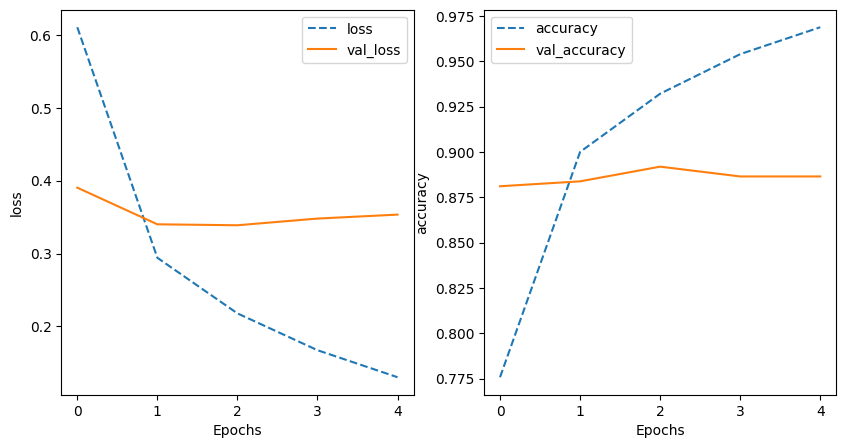

In [6]:
model = train_and_evaluate()

1/1 [==============================] - 0s 72ms/step


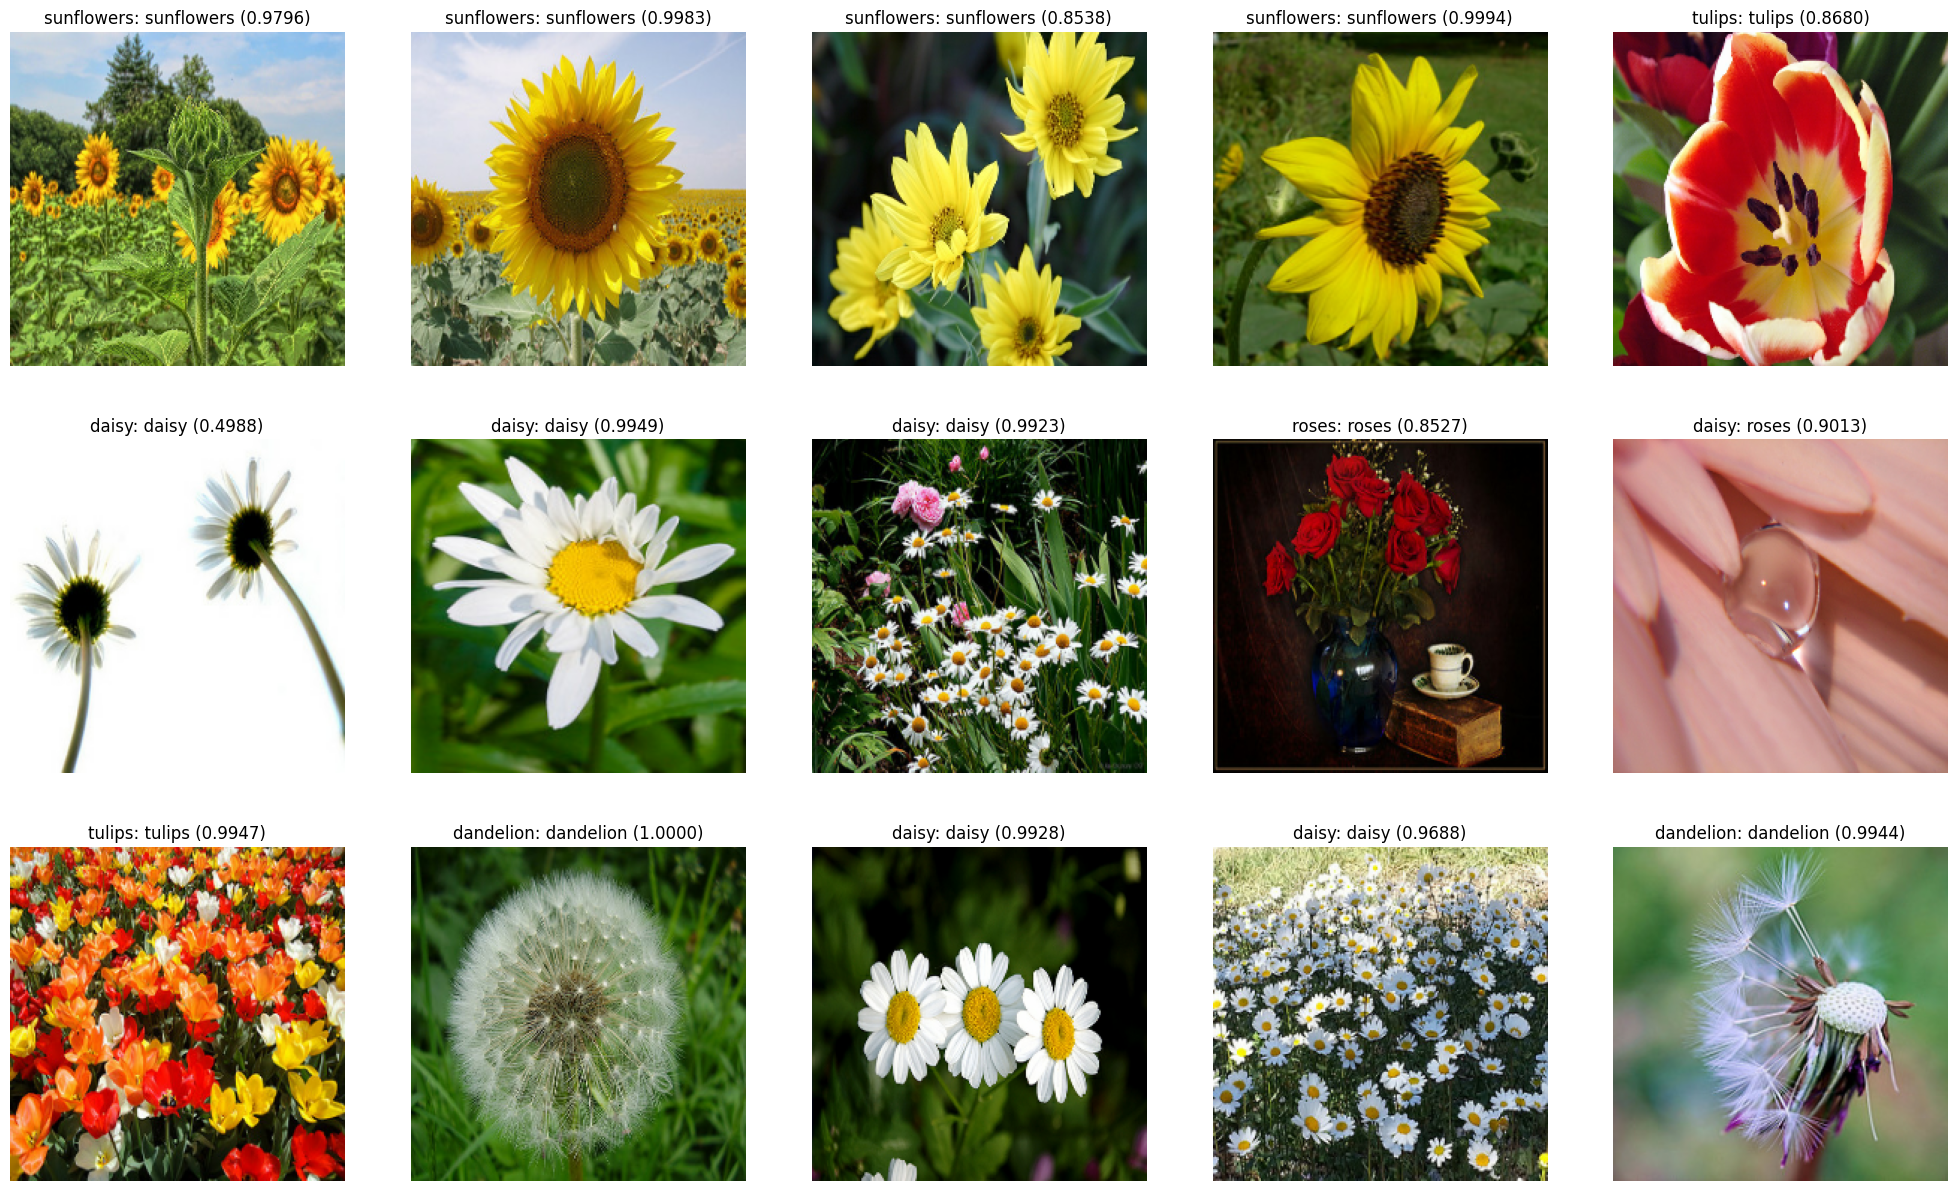

In [7]:
plot_predictions(model, "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv")

## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.